In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import joblib

Total samples: 8132
Accuracy: 0.9429414658140679
Classification Report:
               precision    recall  f1-score   support

Early_blight       0.95      0.89      0.92      2002
     Healthy       0.96      0.98      0.97      3221
 Late_blight       0.92      0.94      0.93      2909

    accuracy                           0.94      8132
   macro avg       0.94      0.94      0.94      8132
weighted avg       0.94      0.94      0.94      8132



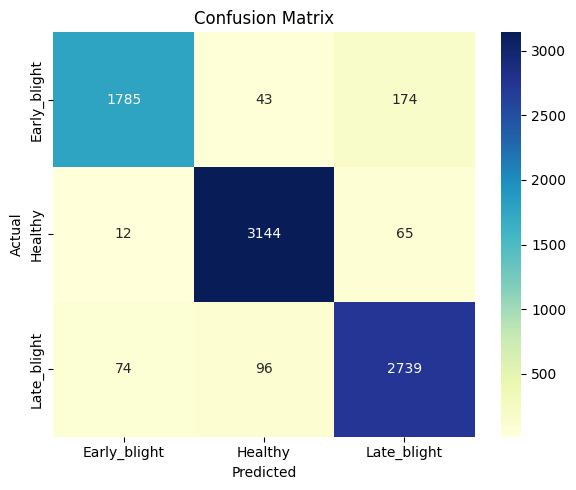

In [5]:
import os
import cv2
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dataset paths
train_dir = r"C:\Users\HP\Desktop\lp\dataset\train"
validation_dir = r"C:\Users\HP\Desktop\lp\dataset\validation"
image_size = (64, 64)

# Class label mapping
label_map = {"Early_blight": 0, "Healthy": 1, "Late_blight": 2}
label_names = list(label_map.keys())

def load_images(folder_path, label):
    data, labels = [], []
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return [], []
    
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_name in image_files:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, image_size)
        img = img.flatten().astype('float32') / 255.0
        data.append(img)
        labels.append(label)
    return data, labels

# Load all images from train and validation directories
X, y = [], []

for label_name, label_id in label_map.items():
    for base_dir in [train_dir, validation_dir]:
        folder = os.path.join(base_dir, label_name)
        data, labels = load_images(folder, label_id)
        X.extend(data)
        y.extend(labels)

X = np.array(X)
y = np.array(y)

print(f"Total samples: {len(X)}")

# PCA for dimensionality reduction
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

# Train the model using all data
model = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale')
model.fit(X_pca, y)

# Predict on same data (for visual analysis)
y_pred = model.predict(X_pca)

# Evaluation
print("Accuracy:", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred, target_names=label_names))

# Confusion Matrix Plot
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
train_dir = r'C:\Users\HP\Desktop\lp\dataset\train'
validation_dir = r'C:\Users\HP\Desktop\lp\dataset\validation'

# Augmentation for training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation
validation_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),   # Bigger size for more features
    batch_size=32,            # Larger batch for better convergence
    class_mode='categorical',
    shuffle=True              # Shuffle for better generalization
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6505 images belonging to 3 classes.
Found 1627 images belonging to 3 classes.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(3, activation='softmax')  # 3 classes: Healthy, Early Blight, Late Blight
])

In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Increased for better convergence
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    verbose=1
)

Epoch 1/10
203/203 [==============================] - 785s 4s/step - loss: 0.8855 - accuracy: 0.5806 - val_loss: 1.0296 - val_accuracy: 0.5781
Epoch 2/10
203/203 [==============================] - 795s 4s/step - loss: 0.6530 - accuracy: 0.7157 - val_loss: 1.1397 - val_accuracy: 0.6037
Epoch 3/10
203/203 [==============================] - 842s 4s/step - loss: 0.5639 - accuracy: 0.7613 - val_loss: 0.5879 - val_accuracy: 0.7362
Epoch 4/10
203/203 [==============================] - 828s 4s/step - loss: 0.5166 - accuracy: 0.7856 - val_loss: 0.7573 - val_accuracy: 0.7300
Epoch 5/10
203/203 [==============================] - 831s 4s/step - loss: 0.4374 - accuracy: 0.8262 - val_loss: 0.4338 - val_accuracy: 0.8375
Epoch 6/10
203/203 [==============================] - 824s 4s/step - loss: 0.4205 - accuracy: 0.8305 - val_loss: 0.6447 - val_accuracy: 0.7531
Epoch 7/10
203/203 [==============================] - 7561s 37s/step - loss: 0.3580 - accuracy: 0.8574 - val_loss: 0.8082 - val_accuracy: 0.72

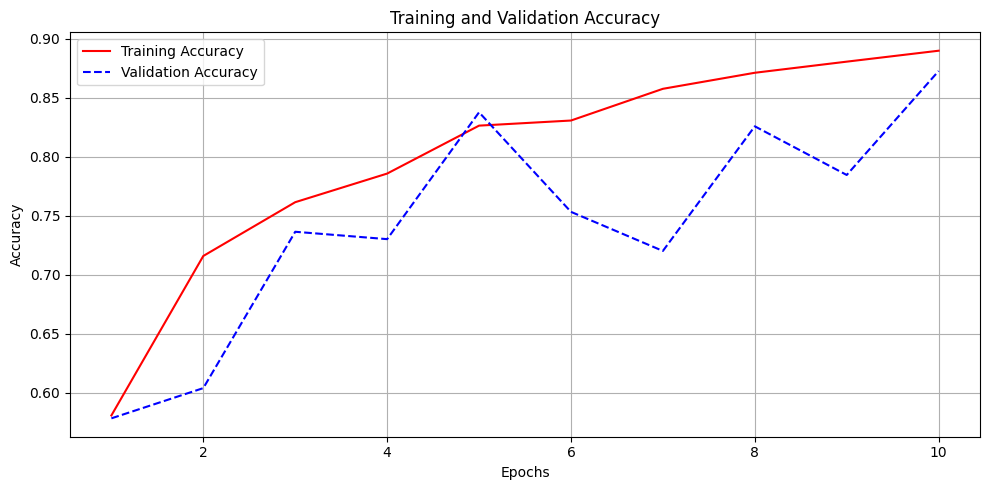

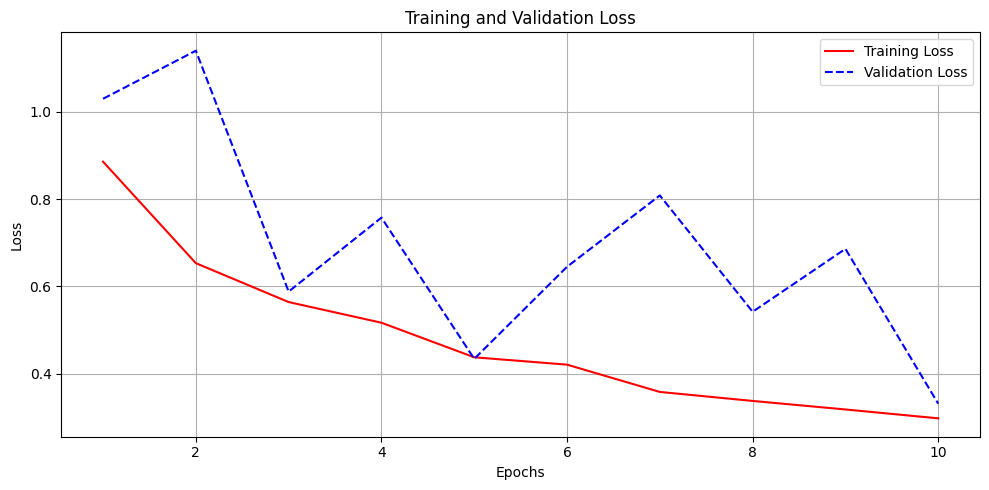

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

51/51 [==============================] - 41s 778ms/step
Confusion Matrix:
[[364  20  16]
 [  6 635   4]
 [142  27 413]]


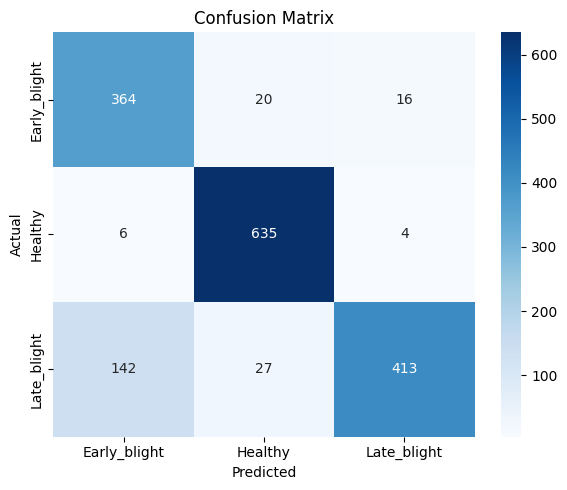


Classification Report:
              precision    recall  f1-score   support

Early_blight       0.71      0.91      0.80       400
     Healthy       0.93      0.98      0.96       645
 Late_blight       0.95      0.71      0.81       582

    accuracy                           0.87      1627
   macro avg       0.87      0.87      0.86      1627
weighted avg       0.89      0.87      0.87      1627



In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
true_labels = validation_generator.classes

# Label names (ensure order matches your generator's class indices)
class_labels = list(validation_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_labels, y_pred)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification report
print('\nClassification Report:')
print(classification_report(true_labels, y_pred, target_names=class_labels))

In [12]:
from sklearn.linear_model import LogisticRegression
import joblib

model = LogisticRegression(max_iter=500)
model.fit(X, y)  # Make sure X and y are preprocessed like in the Flask app
joblib.dump(model, "model/model.pkl")

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['model/model.pkl']